## MONAI deep learning affine registration of CT images with landmarks

### Team members
1. Taofik Ahmed Suleiman
2. Daniel Tweneboah Anyimadu

##### This project has been achieved in three key pipelines, aside adopting the preprocessing and data convertion already done in the ElastixImplentation.ipynb:
1. MONAI deep learning registration data preparation and loading
2. Monai deep learning registration setup - Defining hyperparameters and loss function 
3. Models training and prediction - we have trained the following models:

    SegResNet

    VNet

    Autoencoder
    
    HighResNet

Install the needed monai packages 

In [1]:
#!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
#!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

c:\Users\sulei\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\sulei\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\sulei\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# import the libraries 
import os
import glob
import json
import time
import tempfile
import warnings
from pprint import pprint
import pandas as pd



# data science imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# PyTorch imports
import torch
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.utils.tensorboard import SummaryWriter

# MONAI imports
from monai.apps import download_and_extract
from monai.data import Dataset, CacheDataset, DataLoader
from monai.data.utils import list_data_collate
from monai.losses import BendingEnergyLoss

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

from monai.metrics import DiceMetric
from monai.networks.blocks import Warp
from monai.networks.nets import SegResNet
from monai.utils import set_determinism, first
from monai.config import print_config
from monai.transforms import (
    Compose,
    LoadImaged,
    MapTransform,
    RandAffined,
    Resized,
    ScaleIntensityRanged,
)

set_determinism(seed=0)
torch.backends.cudnn.benchmark = True
warnings.filterwarnings("ignore")


Using TensorFlow backend.


In [3]:
# set data directory 

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\sulei\AppData\Local\Temp\tmp2ak8g11x


### 1. MONAI deep learning registration data preparation and loading affine transforms

We created classes to transform the keypoints, and defined several function all found in the monai_utils.py.


Steps:
1. get_files Function: This function is used to prepare the files in the correct order, it processes the fixed and moving images with their landmarks.
2. LoadKeypoints, and TransformKeypoints classes: since Monai are different for images, we need to define a customized transform to handle our landmarks.
3. Apply these clases to build a tranform pipelines for the training and validation process
4. Visualization

In [4]:
# file directory
data_dir = r'C:\Users\sulei\Downloads\MAIA Girona\MIRA\Project\train12\deepL'

def get_files(data_dir):
    """
    Get files for image registration, using one out of every four samples as val set
    """
    file_list = os.listdir(data_dir)
    # Get a list of all files in the input directory
    file_list = [f for f in os.listdir(data_dir) if f.endswith('_eBHCT.nii')]

    data = {"training_paired_images": [], "registration_val": []}

    for i, moving_image_name in enumerate(file_list):
        # Extract case name from the moving image name
        case_name = moving_image_name.split('_')[0]

        # Construct the file paths for fixed and moving images
        fixed_image_path = os.path.join(data_dir, f"{case_name}_iBHCT.nii")
        moving_image_path = os.path.join(data_dir, f"{case_name}_eBHCT.nii")

        # Construct the file paths for fixed and moving landmarks
        fixed_landmark_path = os.path.join(data_dir, f"{case_name}_300_iBH_xyz_r1.txt")
        moving_landmark_path = os.path.join(data_dir, f"{case_name}_300_eBH_xyz_r1.txt")

        # Create a dictionary for each pair of fixed and moving images with landmarks
        pair = {
            "fixed_image": fixed_image_path,
            "moving_image": moving_image_path,
            "fixed_landmarks": fixed_landmark_path,
            "moving_landmarks": moving_landmark_path,
        }

        if i % 4 == 3:
            # Use one out of every four samples as val set
            data["registration_val"].append(pair)
        else:
            data["training_paired_images"].append(pair)

    return data


# Get the file information
file_info = get_files(data_dir)

pprint(file_info["training_paired_images"])
pprint(file_info["registration_val"]) 

[{'fixed_image': 'C:\\Users\\sulei\\Downloads\\MAIA '
                 'Girona\\MIRA\\Project\\train12\\deepL\\copd1_iBHCT.nii',
  'fixed_landmarks': 'C:\\Users\\sulei\\Downloads\\MAIA '
                     'Girona\\MIRA\\Project\\train12\\deepL\\copd1_300_iBH_xyz_r1.txt',
  'moving_image': 'C:\\Users\\sulei\\Downloads\\MAIA '
                  'Girona\\MIRA\\Project\\train12\\deepL\\copd1_eBHCT.nii',
  'moving_landmarks': 'C:\\Users\\sulei\\Downloads\\MAIA '
                      'Girona\\MIRA\\Project\\train12\\deepL\\copd1_300_eBH_xyz_r1.txt'},
 {'fixed_image': 'C:\\Users\\sulei\\Downloads\\MAIA '
                 'Girona\\MIRA\\Project\\train12\\deepL\\copd2_iBHCT.nii',
  'fixed_landmarks': 'C:\\Users\\sulei\\Downloads\\MAIA '
                     'Girona\\MIRA\\Project\\train12\\deepL\\copd2_300_iBH_xyz_r1.txt',
  'moving_image': 'C:\\Users\\sulei\\Downloads\\MAIA '
                  'Girona\\MIRA\\Project\\train12\\deepL\\copd2_eBHCT.nii',
  'moving_landmarks': 'C:\\Users\\sulei

Customized transforms for the landmarks

In [5]:
class LoadKeypoints(MapTransform):
    """
    Load keypoints from TXT file
    """

    def __init__(self, keys_fixed_landmarks, keys_moving_landmarks):
        super().__init__(keys_fixed_landmarks + keys_moving_landmarks)
        self.keys_fixed_landmarks = keys_fixed_landmarks
        self.keys_moving_landmarks = keys_moving_landmarks

    def __call__(self, data):
        d = dict(data)
        
        for key_fixed, key_moving in zip(self.keys_fixed_landmarks, self.keys_moving_landmarks):
            # Load keypoints from TXT file
            keypoints_fixed = np.loadtxt(d[key_fixed])
            keypoints_moving = np.loadtxt(d[key_moving])

            # Convert to torch tensor
            keypoints_fixed = torch.as_tensor(keypoints_fixed)
            keypoints_moving = torch.as_tensor(keypoints_moving)

            # Update data dictionary
            d[key_fixed] = keypoints_fixed  # [N, 3]
            d[key_moving] = keypoints_moving  # [N, 3]

        return d
    
class TransformKeypoints(MapTransform):
    """
    Applies any potential linear image transformation to keypoint values
    """

    def __init__(self, keys_fixed_landmarks, keys_moving_landmarks, keys_fixed_images, keys_moving_images, ras=False):
        super().__init__(keys_fixed_landmarks + keys_moving_landmarks + keys_fixed_images + keys_moving_images)
        self.keys_fixed_landmarks = keys_fixed_landmarks
        self.keys_moving_landmarks = keys_moving_landmarks
        self.keys_fixed_images = keys_fixed_images
        self.keys_moving_images = keys_moving_images
        self.ras = ras

    def __call__(self, data):
        d = dict(data)

        for kf, km, fi, mi in zip(self.keys_fixed_landmarks, self.keys_moving_landmarks, self.keys_fixed_images, self.keys_moving_images):
            # Get image meta data
            image_fixed = d[fi]
            image_moving = d[mi]
            meta_fixed = image_fixed.meta
            meta_moving = image_moving.meta

            # Get keypoints
            keypoints_fixed_ijk = d[kf]
            keypoints_moving_ijk = d[km]

            # Get transformation (in voxel space)
            affine_fixed = meta_fixed["affine"]
            original_affine_fixed = torch.as_tensor(meta_fixed["original_affine"], dtype=affine_fixed.dtype, device=affine_fixed.device)
            transforms_affine_fixed = original_affine_fixed.inverse() @ affine_fixed
            transforms_affine_fixed = transforms_affine_fixed.inverse()

            affine_moving = meta_moving["affine"]
            original_affine_moving = torch.as_tensor(meta_moving["original_affine"], dtype=affine_moving.dtype, device=affine_moving.device)
            transforms_affine_moving = original_affine_moving.inverse() @ affine_moving
            transforms_affine_moving = transforms_affine_moving.inverse()

            if self.ras:
                # RAS space
                transforms_affine_fixed = original_affine_fixed @ transforms_affine_fixed
                transforms_affine_moving = original_affine_moving @ transforms_affine_moving

            # Apply transformation to keypoints
            keypoints_fixed_ijk_moved = torch.cat((keypoints_fixed_ijk, torch.ones((keypoints_fixed_ijk.shape[0], 1))), dim=1)
            keypoints_fixed_ijk_moved = (transforms_affine_fixed @ keypoints_fixed_ijk_moved.T).T
            keypoints_fixed_ijk_moved = keypoints_fixed_ijk_moved[:, :3]
            keypoints_fixed_ijk_moved = keypoints_fixed_ijk_moved.float()

            keypoints_moving_ijk_moved = torch.cat((keypoints_moving_ijk, torch.ones((keypoints_moving_ijk.shape[0], 1))), dim=1)
            keypoints_moving_ijk_moved = (transforms_affine_moving @ keypoints_moving_ijk_moved.T).T
            keypoints_moving_ijk_moved = keypoints_moving_ijk_moved[:, :3]
            keypoints_moving_ijk_moved = keypoints_moving_ijk_moved.float()

            d[kf] = keypoints_fixed_ijk_moved  # [N, 3]
            d[km] = keypoints_moving_ijk_moved  # [N, 3]

        return d

Tranform pipelines for our training and validation - Here we applied our customized landmark classes and also reduced our image resolution

In [6]:
full_res_training = False

if full_res_training:
    target_res = [224, 192, 224]
    spatial_size = [-1, -1, -1]
else:
    target_res = [96, 96, 96]
    spatial_size = target_res

train_transforms = Compose(
    [
        LoadImaged(keys=["fixed_image", "moving_image"], ensure_channel_first=True),
        LoadKeypoints(keys_fixed_landmarks=["fixed_landmarks"], keys_moving_landmarks=["moving_landmarks"]),
        ScaleIntensityRanged(
            keys=["fixed_image", "moving_image"],
            a_min=-1200,
            a_max=400,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Resized(
            keys=["fixed_image", "moving_image"],
            mode=("trilinear", "trilinear"),
            align_corners=(True, True),
            spatial_size=spatial_size,
        ),
        RandAffined(
            keys=["fixed_image", "moving_image"],
            mode=("bilinear", "bilinear"),
            prob=0.8,
            shear_range=0.2,
            translate_range=int(25 * target_res[0] / 224),
            rotate_range=np.pi / 180 * 15,
            scale_range=0.2,
            padding_mode=("zeros", "zeros"),
        ),
        TransformKeypoints(
            keys_fixed_landmarks=["fixed_landmarks"],
            keys_moving_landmarks=["moving_landmarks"],
            keys_fixed_images=["fixed_image"],
            keys_moving_images=["moving_image"],
        ),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["fixed_image", "moving_image"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["fixed_image", "moving_image"],
            a_min=-1200,
            a_max=400,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Resized(
            keys=["fixed_image", "moving_image"],
            mode=("trilinear", "trilinear"),
            align_corners=(True, True),
            spatial_size=spatial_size,
        ),
        LoadKeypoints(keys_fixed_landmarks=["fixed_landmarks"], keys_moving_landmarks=["moving_landmarks"]),
        TransformKeypoints(
            keys_fixed_landmarks=["fixed_landmarks"],
            keys_moving_landmarks=["moving_landmarks"],
            keys_fixed_images=["fixed_image"],
            keys_moving_images=["moving_image"],
        ),
    ]
)

Apply Monai DataLoader and visualize the results for sanity check

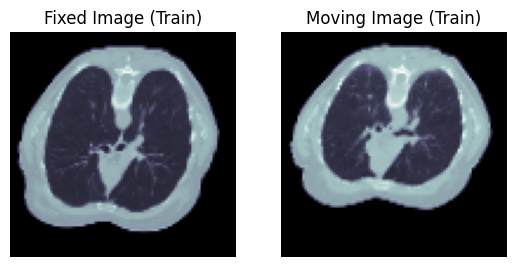

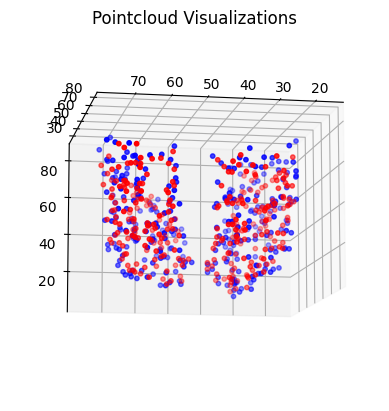

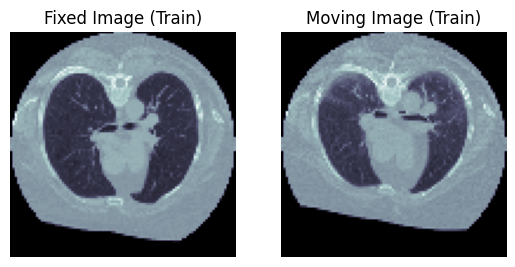

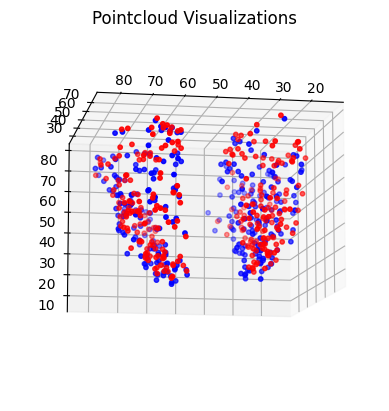

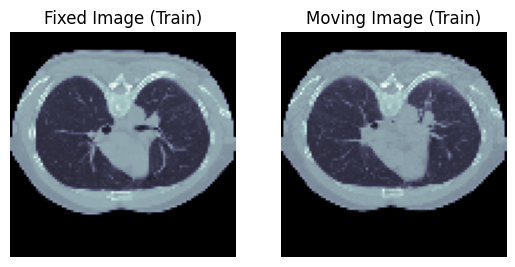

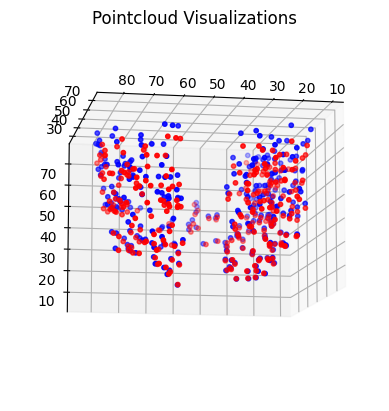

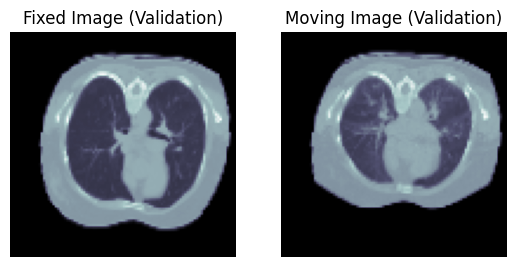

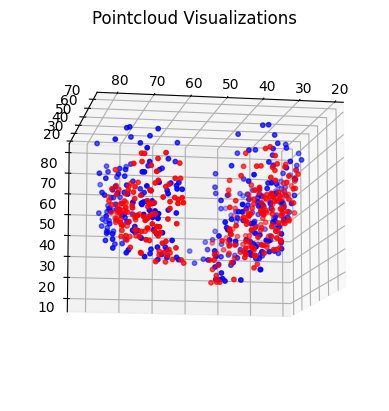

In [18]:
# Assuming you have already defined `file_info` and `train_transforms` as in your previous code
train_files = file_info["training_paired_images"]
val_files = file_info["registration_val"]

# Create datasets and loaders for both training and validation
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True)

# Function to visualize images and point clouds
def visualize_sample(axs, image, title):
    slice_idx = int(target_res[0] * 95.0 / 224)
    axs.imshow(image[:, :, slice_idx], cmap="bone", origin="lower")
    axs.set_title(title)
    axs.set_axis_off()

def visualize_pointcloud(ax, points, color):
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=10.0, marker="o", color=color)
    ax.view_init(-10, 80)
    ax.set_aspect("auto")
    ax.set_title("Pointcloud Visualizations")

# Visualize samples from the training set
for i, train_data in enumerate(train_loader):
    fixed_image_train = train_data["fixed_image"][0][0].permute(1, 0, 2)
    moving_image_train = train_data["moving_image"][0][0].permute(1, 0, 2)
    fixed_points_train = train_data["fixed_landmarks"][0]
    moving_points_train = train_data["moving_landmarks"][0]

    # Plot images
    fig_train, axs_train = plt.subplots(1, 2)
    visualize_sample(axs_train[0], fixed_image_train, "Fixed Image (Train)")
    visualize_sample(axs_train[1], moving_image_train, "Moving Image (Train)")
    plt.show()

    # Plot point clouds
    fig_pc_train = plt.figure()
    ax_pc_train = fig_pc_train.add_subplot(projection="3d")
    visualize_pointcloud(ax_pc_train, fixed_points_train, "blue")
    visualize_pointcloud(ax_pc_train, moving_points_train, "red")
    plt.show()

    if i == 2:  # Visualize only a few samples from the training set for brevity
        break

# Visualize samples from the validation set
for i, val_data in enumerate(val_loader):
    fixed_image_val = val_data["fixed_image"][0][0].permute(1, 0, 2)
    moving_image_val = val_data["moving_image"][0][0].permute(1, 0, 2)
    fixed_points_val = val_data["fixed_landmarks"][0]
    moving_points_val = val_data["moving_landmarks"][0]

    # Plot images
    fig_val, axs_val = plt.subplots(1, 2)
    visualize_sample(axs_val[0], fixed_image_val, "Fixed Image (Validation)")
    visualize_sample(axs_val[1], moving_image_val, "Moving Image (Validation)")
    plt.show()

    # Plot point clouds
    fig_pc_val = plt.figure()
    ax_pc_val = fig_pc_val.add_subplot(projection="3d")
    visualize_pointcloud(ax_pc_val, fixed_points_val, "blue")
    visualize_pointcloud(ax_pc_val, moving_points_val, "red")
    plt.show()

    if i == 0:  # Visualize only one sample from the validation set for brevity
        break


### 2. Monai deep learning registration setup - Defining hyperparameters and loss function

We created several function to achieve this step as highlighted below:


Steps:
1. Hyperparameter: The hyperparameters are set in a way to allow the optimization to be driven only by TRE loss since we are interested in points.
2. Model Forward Pass: The forward function is responsible for the forward pass of the model. It predicts the Displacement Field (DDF) and warps the moving image based on the predicted DDF.
3. Collate Function: This ensures that keypoints are aligned for easy collation during batch processing.
4. Target Registration Error (TRE) Calculation: The tre function computes the TRE loss between fixed and moving landmarks.
5. Loss Function: The loss_fun function defines the multi-target loss used for the model optimization. It includes components for TRE, MSE, and Bending Energy.

Set hyperparameters

In [19]:
batch_size = 1
lr = 1e-4
weight_decay = 1e-5
max_epochs = 50

# Image voxel size at target resolution
vx = np.array([1.5, 1.5, 1.5]) / (np.array(target_res) / np.array([224, 192, 224]))
# vx = [0.6, 0.6, 2.5]

# Loss weights (set to zero to disable loss term)
lam_t = 1e0  # TRE (keypoint loss)
lam_m = 0    # MSE
lam_r = 0    # Bending loss 

# Write model and tensorboard logs
do_save = True
dir_save = os.path.join(os.getcwd(), "models", "500")
if do_save and not os.path.exists(dir_save):
    os.makedirs(dir_save)


Customazed function for forward, collate, tre and loss fun

In [20]:
def forward(fixed_image, moving_image, fixed_landmarks, model, warp_layer):
    """
    Model forward pass: predict DDF, warp moving images
    """
    batch_size = fixed_image.shape[0]

    # predict DDF through your model
    ddf_image = model(torch.cat((moving_image, fixed_image), dim=1)).float()

    # warp moving image with the predicted ddf
    pred_image = warp_layer(moving_image, ddf_image)

    # warp vectors for keypoints (optional)
    ddf_keypoints = None
    if fixed_landmarks is not None:
        with torch.no_grad():
            offset = torch.as_tensor(fixed_image.shape[-3:]).to(fixed_landmarks.device) / 2
            offset = offset[None][None]
            ddf_keypoints = torch.flip((fixed_landmarks - offset) / offset, (-1,))
        ddf_keypoints = (
            F.grid_sample(ddf_image, ddf_keypoints.view(batch_size, -1, 1, 1, 3))
            .view(batch_size, 3, -1)
            .permute((0, 2, 1))
        )

    return ddf_image, ddf_keypoints, pred_image


def collate_fn(batch):
    """
    Custom collate function.
    Aligns keypoints for easy collation.
    """
    max_length = 0
    for data in batch:
        length = data["fixed_landmarks"].shape[0]
        if length > max_length:
            max_length = length

    for data in batch:
        length = data["fixed_landmarks"].shape[0]
        data["fixed_landmarks"] = torch.cat(
            (data["fixed_landmarks"], float("nan") * torch.ones((max_length - length, 3))), dim=0
        )
        data["moving_landmarks"] = torch.cat(
            (data["moving_landmarks"], float("nan") * torch.ones((max_length - length, 3))), dim=0
        )

    return {
        "fixed_image": torch.stack([data["fixed_image"] for data in batch]),
        "moving_image": torch.stack([data["moving_image"] for data in batch]),
        "fixed_landmarks": torch.stack([data["fixed_landmarks"] for data in batch]),
        "moving_landmarks": torch.stack([data["moving_landmarks"] for data in batch]),
        # Add other keys if needed
    }


In [21]:
def tre(fixed, moving, vx=None):
    """
    Computes target registration error (TRE) loss for keypoint matching.
    """
    if vx is None:
        return ((fixed - moving) ** 2).sum(-1).sqrt().mean()
    else:
        vx_tensor = torch.tensor(vx, dtype=fixed.dtype, device=fixed.device)
        return (((fixed - moving) * vx_tensor) ** 2).sum(-1).sqrt().mean()
    



def loss_fun(
    fixed_image,
    pred_image,
    fixed_landmarks,
    pred_landmarks,
    ddf_image,
    lam_t,
    lam_m,
    lam_r,
):
    """
    Custom multi-target loss:
        - TRE as the main loss component
        - Parametrizable weights for further (optional) components: MSE/BendingEnergy
    Note: Might require "calibration" of lambda weights for the multi-target components,
        e.g., by making a first trial run and manually setting weights to account for different magnitudes
    """
    # Instantiate where necessary
    if lam_m > 0:
        mse_loss = MSELoss()
    if lam_r > 0:
        regularization = BendingEnergyLoss()

    # Compute loss components
    t = tre(fixed_landmarks, pred_landmarks) if lam_t > 0 else 0.0
    m = mse_loss(fixed_image, pred_image) if lam_m > 0 else 0.0
    r = regularization(ddf_image) if lam_r > 0 else 0.0

    # Weighted combination
    return lam_t * t + lam_m * m + lam_r * r


In [22]:
train_files = file_info["training_paired_images"]
val_files = file_info["registration_val"]

# Cached datasets for high performance during batch generation
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)

# DataLoaders, now with a custom function `collate_fn`, to rectify the ragged keypoint tensors
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

Loading dataset:   0%|          | 0/3 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


### 3. Model training and prediction

We trained the following models using the steps highlighted below

    - SegResNet

    - VNet

    - Autoencoder
    
    - HighResNet


Steps:
1. Model initialization: We used the SegResNet Model, and an optimization set up using Adam optimizer.
2. Training and Validation Loop: The training and prediction is carried out here using the TRE as the key loss and best model is saved
3. Pretrained Model Loading: At any time, we can load the saved model and perform prediction
4. Visualization of final results
5. Result compilation 

SegResNet

In [23]:
# Model
model = SegResNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=3,
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    dropout_prob=0.2,
)
warp_layer = Warp()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs)

Training and Validation process

In [24]:
# Tensorboard
if do_save:
    writer = SummaryWriter(log_dir=dir_save)

# Training loop
val_interval = 1
best_eval_tre = float("inf")
log_train_loss = []
log_train_tre = []
log_val_tre = []
log_val_loss = []

pth_best_tre, pth_latest = "", ""

for epoch in range(max_epochs):
    # ==============================================
    # Train
    # ==============================================
    t0_train = time.time()
    model.train()

    epoch_loss, n_steps, tre_before, tre_after = 0, 0, 0, 0
    for batch_data in train_loader:
        # Get data
        fixed_image = batch_data["fixed_image"]
        moving_image = batch_data["moving_image"]
        fixed_keypoints = batch_data["fixed_landmarks"]
        moving_keypoints = batch_data["moving_landmarks"]
        n_steps += 1
        # Forward pass and loss
        optimizer.zero_grad()
        ddf_image, ddf_keypoints, pred_image = forward(
            fixed_image, moving_image, fixed_keypoints, model, warp_layer
        )
        loss = loss_fun(
            fixed_image,
            pred_image,
            fixed_keypoints + ddf_keypoints,
            moving_keypoints,
            ddf_image,
            lam_t,
            lam_m,
            lam_r,
        )
        # Optimise
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # TRE before (voxel space)
        tre_before += tre(fixed_keypoints, moving_keypoints, vx = vx)
        tre_after += tre(fixed_keypoints + ddf_keypoints, moving_keypoints, vx = vx)

    # Scheduler step
    lr_scheduler.step()
    # Loss
    epoch_loss /= n_steps
    tre_before /= n_steps
    tre_after /= n_steps
    log_train_tre.append(tre_after.item())
    log_train_loss.append(epoch_loss)
    if do_save:
        writer.add_scalar("train_loss", epoch_loss, epoch)
    print(f"{epoch + 1} | loss={epoch_loss:.6f}")

    # Mean TRE
    tre_before /= n_steps
    tre_after /= n_steps
    print(
            f"{epoch + 1} | tre_before_train={tre_before:.3f}, tre_after_train={tre_after:.3f}, elapsed time: {time.time()-t0_train:.2f} sec."
    )

    # ==============================================
    # Eval
    # ==============================================
    if (epoch + 1) % val_interval == 0:
        t0_eval = time.time()
        model.eval()

        val_epoch_loss , n_steps, tre_before, tre_after = 0, 0, 0, 0
        with torch.no_grad():
            for batch_data in val_loader:
                # Get data
                fixed_image = batch_data["fixed_image"]
                moving_image = batch_data["moving_image"]
                fixed_keypoints = batch_data["fixed_landmarks"]
                moving_keypoints = batch_data["moving_landmarks"]
                n_steps += 1

                # Infer
                ddf_image, ddf_keypoints, pred_image = forward(
                    fixed_image, moving_image, fixed_keypoints, model, warp_layer
                )

                # Loss for validation
                val_loss = loss_fun(
                    fixed_image,
                    pred_image,
                    fixed_keypoints + ddf_keypoints,
                    moving_keypoints,
                    ddf_image,
                    lam_t,
                    lam_m,
                    lam_r,
                )
                val_epoch_loss += val_loss.item()

                # TRE

                tre_before += tre(fixed_keypoints , moving_keypoints, vx=vx)
                tre_after += tre(fixed_keypoints + ddf_keypoints, moving_keypoints, vx=vx)

        # Mean TRE
        tre_before /= n_steps
        tre_after /= n_steps
        val_epoch_loss /= n_steps
        log_val_loss.append(val_epoch_loss)
        log_val_tre.append(tre_after.item())
        if do_save:
            writer.add_scalar("val_tre", tre_after, epoch)
       

        print(
            f"{epoch + 1} | tre_before_val={tre_before:.3f}, tre_after_val={tre_after:.3f}, elapsed time: {time.time() - t0_train:.2f} sec."
            )


        if tre_after < best_eval_tre:
            best_eval_tre = tre_after
            if do_save:
                # Save best model based on TRE
                if pth_best_tre != "":
                    os.remove(os.path.join(dir_save, pth_best_tre))
                pth_best_tre = f"segresnet_kpt_loss_best_tre_{epoch + 1}_{best_eval_tre:.3f}.pth"
                torch.save(model.state_dict(), os.path.join(dir_save, pth_best_tre))
                print(f"{epoch + 1} | Saving best TRE model: {pth_best_tre}")

        if do_save:
            # Save latest model
            if pth_latest != "":
                os.remove(os.path.join(dir_save, pth_latest))
            pth_latest = "segresnet_kpt_loss_latest.pth"
            torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))


1 | loss=6.234560
1 | tre_before_train=6.507, tre_after_train=6.656, elapsed time: 12.19 sec.
1 | tre_before_val=30.364, tre_after_val=30.668, elapsed time: 13.50 sec.
1 | Saving best TRE model: segresnet_kpt_loss_best_tre_1_30.668.pth
2 | loss=5.782505
2 | tre_before_train=6.477, tre_after_train=6.146, elapsed time: 12.19 sec.
2 | tre_before_val=30.364, tre_after_val=30.410, elapsed time: 13.46 sec.
2 | Saving best TRE model: segresnet_kpt_loss_best_tre_2_30.410.pth
3 | loss=5.652596
3 | tre_before_train=6.453, tre_after_train=6.032, elapsed time: 12.54 sec.
3 | tre_before_val=30.364, tre_after_val=30.260, elapsed time: 14.03 sec.
3 | Saving best TRE model: segresnet_kpt_loss_best_tre_3_30.260.pth
4 | loss=5.535046
4 | tre_before_train=6.471, tre_after_train=5.968, elapsed time: 14.40 sec.
4 | tre_before_val=30.364, tre_after_val=30.062, elapsed time: 15.91 sec.
4 | Saving best TRE model: segresnet_kpt_loss_best_tre_4_30.062.pth
5 | loss=5.297263
5 | tre_before_train=6.441, tre_after_

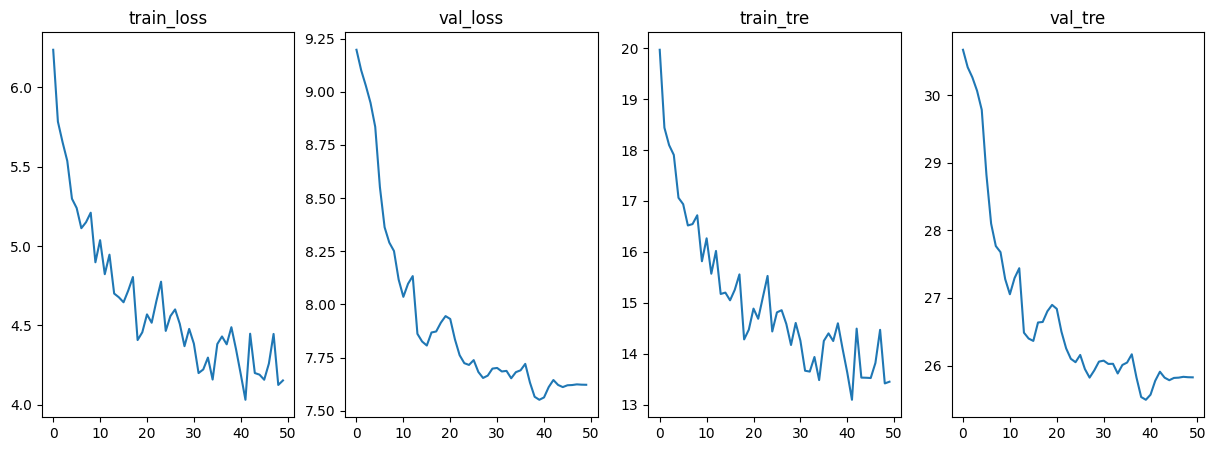

In [25]:
# log_val_tre = [x.item() for x in log_val_tre]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].plot(log_train_loss)
axs[0].title.set_text("train_loss")
axs[1].plot(log_val_loss)
axs[1].title.set_text("val_loss")
axs[2].plot(log_train_tre)
axs[2].title.set_text("train_tre")
axs[3].plot(log_val_tre)
axs[3].title.set_text("val_tre")
plt.show()

Load pretrained model and perform forward pass

In [32]:
load_pretrained_model_weights = False
if load_pretrained_model_weights:
    dir_load = dir_save  # folder where network weights are stored
    # instantiate warp layer
    warp_layer = Warp()
    # instantiate model
    model = SegResNet(
        spatial_dims=3,
        in_channels=2,
        out_channels=3,
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        dropout_prob=0.2,
    )
    # load model weights
    filename_best_model = glob.glob(os.path.join(dir_load, "segresnet_kpt_loss_best_tre*"))[0]
    model.load_state_dict(torch.load(filename_best_model))
    # to GPU
    model.to(device)

set_determinism(seed=1)
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)

# Forward pass
model.eval()
with torch.no_grad():
    ddf_image, ddf_keypoints, pred_image = forward(
            check_data["fixed_image"],
            check_data["moving_image"],
            check_data["fixed_landmarks"],
            model,
            warp_layer,
        )

Visualization of image pair before and after registration

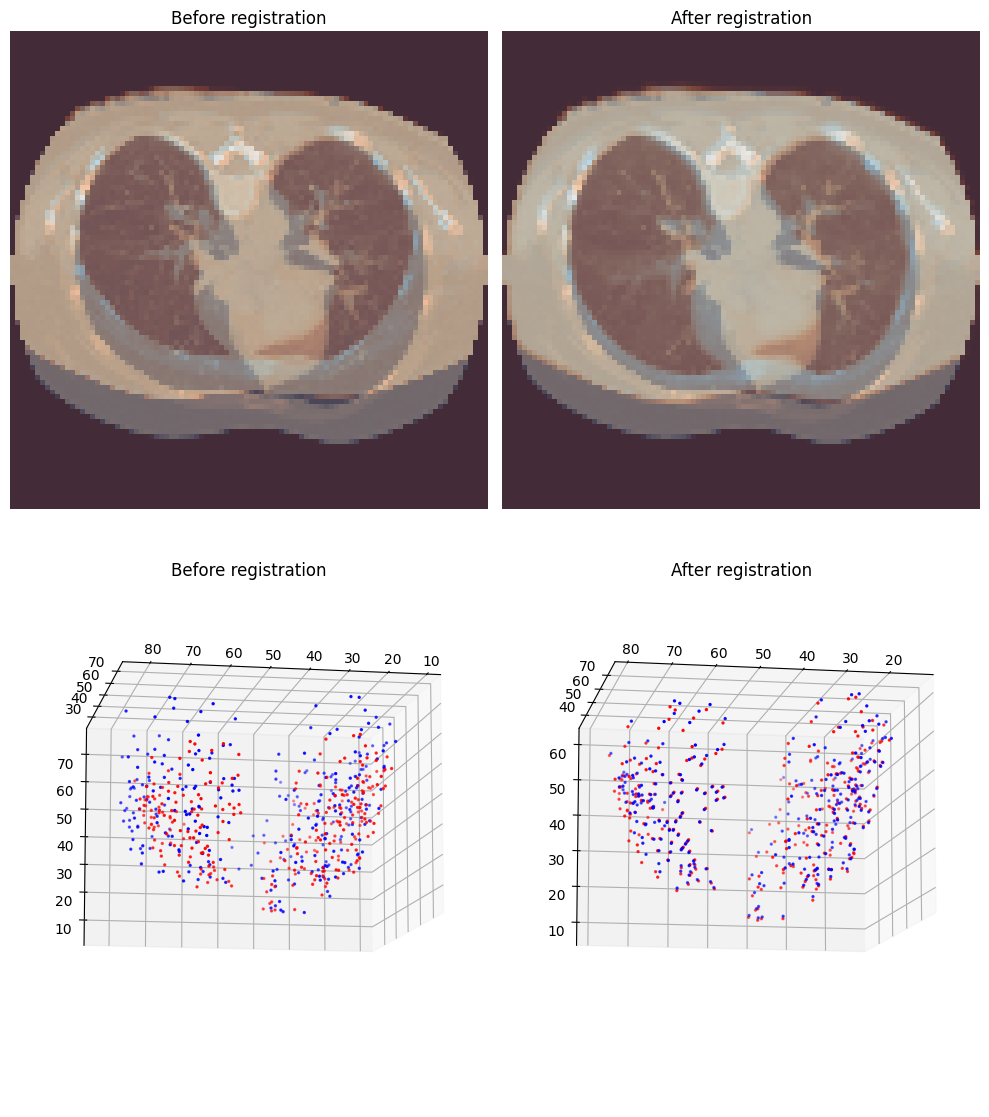

In [33]:
def overlay_img(img1, img2, slice_idx, ax, title=None):
    ax.imshow(1 - img1[:, :, slice_idx], cmap="Blues", origin="lower")
    ax.imshow(1 - img2[:, :, slice_idx], cmap="Oranges", origin="lower", alpha=0.5)
    if title is not None:
        ax.set_title(title)  # Use set_title instead of title.set_text

# Image and label visualization
fixed_image = check_data["fixed_image"][0][0].permute(1, 0, 2)
moving_image = check_data["moving_image"][0][0].permute(1, 0, 2)
pred_image = pred_image[0][0].permute(1, 0, 2)

# Pointcloud visualization
fixed_keypoints = check_data["fixed_landmarks"][0]
moving_keypoints = check_data["moving_landmarks"][0]
moved_keypoints = fixed_keypoints + ddf_keypoints[0]

# Plot images and pointclouds
fig, axs = plt.subplots(2, 2, figsize=(10, 12)) 

# Image visualizations
slice_idx = int(target_res[0] * 95.0 / 224) 
overlay_img(fixed_image, moving_image, slice_idx, axs[0, 0], "Before registration")
overlay_img(fixed_image, pred_image, slice_idx, axs[0, 1], "After registration")

# Pointcloud visualizations
ax = fig.add_subplot(2, 2, 3, projection="3d")
ax.scatter(fixed_keypoints[:, 0], fixed_keypoints[:, 1], fixed_keypoints[:, 2], s=2.0, marker="o", color="blue")
ax.scatter(moving_keypoints[:, 0], moving_keypoints[:, 1], moving_keypoints[:, 2], s=2.0, marker="o", color="red")
ax.view_init(-10, 80)
ax.set_aspect("auto")
ax.set_title("Before registration")

ax = fig.add_subplot(2, 2, 4, projection="3d")
ax.scatter(moved_keypoints[:, 0], moved_keypoints[:, 1], moved_keypoints[:, 2], s=2.0, marker="o", color="blue")
ax.scatter(moving_keypoints[:, 0], moving_keypoints[:, 1], moving_keypoints[:, 2], s=2.0, marker="o", color="red")
ax.view_init(-10, 80)
ax.set_aspect("auto")
ax.set_title("After registration")

# Set axis off for image visualizations
for ax in axs[:, :].flat:
    ax.set_axis_off()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Computre TRE for the entire model

In [49]:
# Function to compute predicted TRE for a dataset using the trained model
def compute_tre_for_dataset(model, dataset, warp_layer, vx=None):
    model.eval()
    predicted_tre_list = []
    tre_without_reg = []

    with torch.no_grad():
        for batch_data in dataset:
            fixed_image = batch_data["fixed_image"]
            moving_image = batch_data["moving_image"]
            fixed_keypoints = batch_data["fixed_landmarks"]
            moving_keypoints = batch_data["moving_landmarks"]

            # Forward pass
            ddf_image, ddf_keypoints, pred_image = forward(
                fixed_image, moving_image, fixed_keypoints, model, warp_layer
            )

            # Compute predicted TRE
            noreg_tre = tre(
                fixed_keypoints,
                moving_keypoints,
                vx=vx,
            )
            tre_without_reg.append(noreg_tre)


            predicted_tre = tre(
                fixed_keypoints,
                (fixed_keypoints + ddf_keypoints),
                vx=vx,
            )
            predicted_tre_list.append(predicted_tre)

    return tre_without_reg, predicted_tre_list

# Compute predicted TRE for validation dataset
initial_tre_val, predicted_tre_val = compute_tre_for_dataset(model, val_loader, warp_layer, vx=vx)

# Display the results in a table
df_results_val = pd.DataFrame({
    #"Case": range(1, len(predicted_tre_val) + 1),
    "Case": 4,
    "TRE without registration (Validation)": initial_tre_val,
    "Predicted TRE (Validation)": predicted_tre_val,
})

# Compute predicted TRE for training dataset
initial_tre_train, predicted_tre_train = compute_tre_for_dataset(model, train_loader, warp_layer, vx=vx)

# Display the results in a table
df_results_train = pd.DataFrame({
    "Case": range(1, len(predicted_tre_train) + 1),
    "TRE without registration (Training)": initial_tre_train,
    "Predicted TRE (Training)": predicted_tre_train
})

# Display the combined results
print(df_results_train)
print(df_results_val)

   Case TRE without registration (Training) Predicted TRE (Training)
0     1                     tensor(25.0160)       metatensor(7.2533)
1     2                     tensor(20.8632)      metatensor(10.2973)
2     3                     tensor(12.9761)       metatensor(6.0914)
   Case TRE without registration (Validation) Predicted TRE (Validation)
0     4                       tensor(30.3643)         metatensor(8.4222)


In [50]:
df_results_train

,Case,TRE without registration (Training),Predicted TRE (Training)
0,1,tensor(25.0160),metatensor(7.2533)
1,2,tensor(20.8632),metatensor(10.2973)
2,3,tensor(12.9761),metatensor(6.0914)


In [51]:
df_results_val

,Case,TRE without registration (Validation),Predicted TRE (Validation)
0,4,tensor(30.3643),metatensor(8.4222)


#### Training for other models 

VNet

In [160]:
from monai.networks.nets import VNet

# Model
model = VNet(spatial_dims=3, in_channels=2, out_channels=3, act=('elu', {'inplace': True}), 
             dropout_prob=0.2, dropout_prob_down=0.5, dropout_prob_up=(0.5, 0.5), dropout_dim=3, bias=False)
warp_layer = Warp()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs)



In [161]:
# Tensorboard
if do_save:
    writer = SummaryWriter(log_dir=dir_save)

# Training loop
val_interval = 1
best_eval_tre = float("inf")
log_train_loss = []
log_train_tre = []
log_val_tre = []
log_val_loss = []

pth_best_tre, pth_latest = "", ""

for epoch in range(max_epochs):
    # ==============================================
    # Train
    # ==============================================
    t0_train = time.time()
    model.train()

    epoch_loss, n_steps, tre_before, tre_after = 0, 0, 0, 0
    for batch_data in train_loader:
        # Get data
        fixed_image = batch_data["fixed_image"]
        moving_image = batch_data["moving_image"]
        fixed_keypoints = batch_data["fixed_landmarks"]
        moving_keypoints = batch_data["moving_landmarks"]
        n_steps += 1
        # Forward pass and loss
        optimizer.zero_grad()
        ddf_image, ddf_keypoints, pred_image = forward(
            fixed_image, moving_image, fixed_keypoints, model, warp_layer
        )
        loss = loss_fun(
            fixed_image,
            pred_image,
            fixed_keypoints + ddf_keypoints,
            moving_keypoints,
            ddf_image,
            lam_t,
            lam_m,
            lam_r,
        )
        # Optimise
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # TRE before (voxel space)
        tre_before += tre(fixed_keypoints, moving_keypoints, vx = vx)
        tre_after += tre(fixed_keypoints + ddf_keypoints, moving_keypoints, vx = vx)

    # Scheduler step
    lr_scheduler.step()
    # Loss
    epoch_loss /= n_steps
    tre_before /= n_steps
    tre_after /= n_steps
    log_train_tre.append(tre_after.item())
    log_train_loss.append(epoch_loss)
    if do_save:
        writer.add_scalar("train_loss", epoch_loss, epoch)
    print(f"{epoch + 1} | loss={epoch_loss:.6f}")

    # Mean TRE
    tre_before /= n_steps
    tre_after /= n_steps
    print(
            f"{epoch + 1} | tre_before_train={tre_before:.3f}, tre_after_train={tre_after:.3f}, elapsed time: {time.time()-t0_train:.2f} sec."
    )

    # ==============================================
    # Eval
    # ==============================================
    if (epoch + 1) % val_interval == 0:
        t0_eval = time.time()
        model.eval()

        val_epoch_loss , n_steps, tre_before, tre_after = 0, 0, 0, 0
        with torch.no_grad():
            for batch_data in val_loader:
                # Get data
                fixed_image = batch_data["fixed_image"]
                moving_image = batch_data["moving_image"]
                fixed_keypoints = batch_data["fixed_landmarks"]
                moving_keypoints = batch_data["moving_landmarks"]
                n_steps += 1

                # Infer
                ddf_image, ddf_keypoints, pred_image = forward(
                    fixed_image, moving_image, fixed_keypoints, model, warp_layer
                )

                # Loss for validation
                val_loss = loss_fun(
                    fixed_image,
                    pred_image,
                    fixed_keypoints + ddf_keypoints,
                    moving_keypoints,
                    ddf_image,
                    lam_t,
                    lam_m,
                    lam_r,
                )
                val_epoch_loss += val_loss.item()

                # TRE

                tre_before += tre(fixed_keypoints , moving_keypoints, vx=vx)
                tre_after += tre(fixed_keypoints + ddf_keypoints, moving_keypoints, vx=vx)

        # Mean TRE
        tre_before /= n_steps
        tre_after /= n_steps
        val_epoch_loss /= n_steps
        log_val_loss.append(val_epoch_loss)
        log_val_tre.append(tre_after.item())
        if do_save:
            writer.add_scalar("val_tre", tre_after, epoch)
       

        print(
            f"{epoch + 1} | tre_before_val={tre_before:.3f}, tre_after_val={tre_after:.3f}, elapsed time: {time.time() - t0_train:.2f} sec."
            )


        if tre_after < best_eval_tre:
            best_eval_tre = tre_after
            if do_save:
                # Save best model based on TRE
                if pth_best_tre != "":
                    os.remove(os.path.join(dir_save, pth_best_tre))
                pth_best_tre = f"VNet_kpt_loss_best_tre_{epoch + 1}_{best_eval_tre:.3f}.pth"
                torch.save(model.state_dict(), os.path.join(dir_save, pth_best_tre))
                print(f"{epoch + 1} | Saving best TRE model: {pth_best_tre}")

        if do_save:
            # Save latest model
            if pth_latest != "":
                os.remove(os.path.join(dir_save, pth_latest))
            pth_latest = "VNet_kpt_loss_latest.pth"
            torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))


1 | loss=6.548649
1 | tre_before_train=6.437, tre_after_train=6.814, elapsed time: 31.10 sec.
1 | tre_before_val=30.364, tre_after_val=30.025, elapsed time: 34.52 sec.
1 | Saving best TRE model: VNet_kpt_loss_best_tre_1_30.025.pth
2 | loss=6.135309
2 | tre_before_train=6.431, tre_after_train=6.437, elapsed time: 35.25 sec.
2 | tre_before_val=30.364, tre_after_val=29.759, elapsed time: 39.99 sec.
2 | Saving best TRE model: VNet_kpt_loss_best_tre_2_29.759.pth
3 | loss=5.960022
3 | tre_before_train=6.402, tre_after_train=6.244, elapsed time: 35.74 sec.
3 | tre_before_val=30.364, tre_after_val=29.435, elapsed time: 39.77 sec.
3 | Saving best TRE model: VNet_kpt_loss_best_tre_3_29.435.pth
4 | loss=5.986105
4 | tre_before_train=6.468, tre_after_train=6.295, elapsed time: 37.21 sec.
4 | tre_before_val=30.364, tre_after_val=29.321, elapsed time: 41.20 sec.
4 | Saving best TRE model: VNet_kpt_loss_best_tre_4_29.321.pth
5 | loss=5.931060
5 | tre_before_train=6.482, tre_after_train=6.249, elapsed

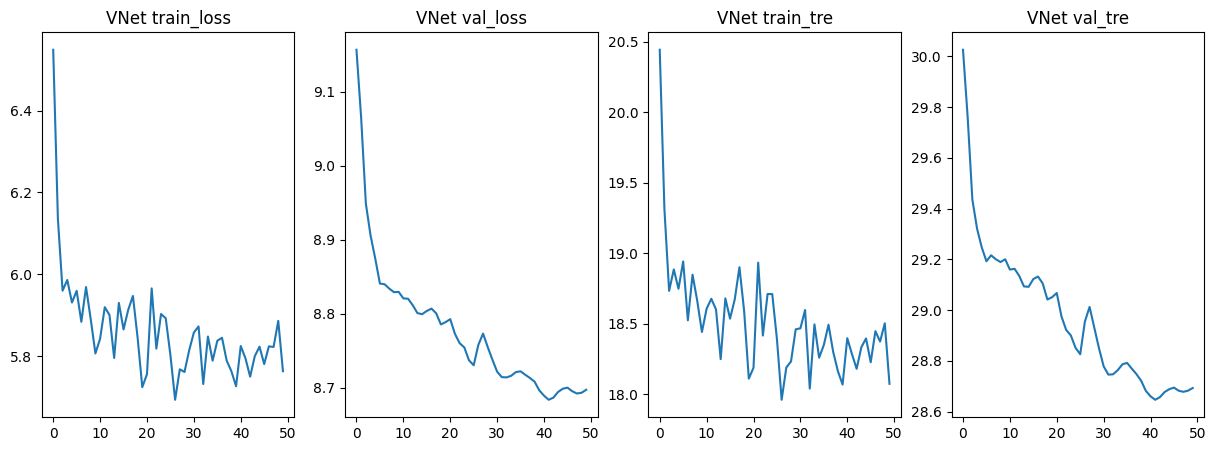

In [162]:
# log_val_tre = [x.item() for x in log_val_tre]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].plot(log_train_loss)
axs[0].title.set_text("VNet train_loss")
axs[1].plot(log_val_loss)
axs[1].title.set_text("VNet val_loss")
axs[2].plot(log_train_tre)
axs[2].title.set_text("VNet train_tre")
axs[3].plot(log_val_tre)
axs[3].title.set_text("VNet val_tre")
plt.show()

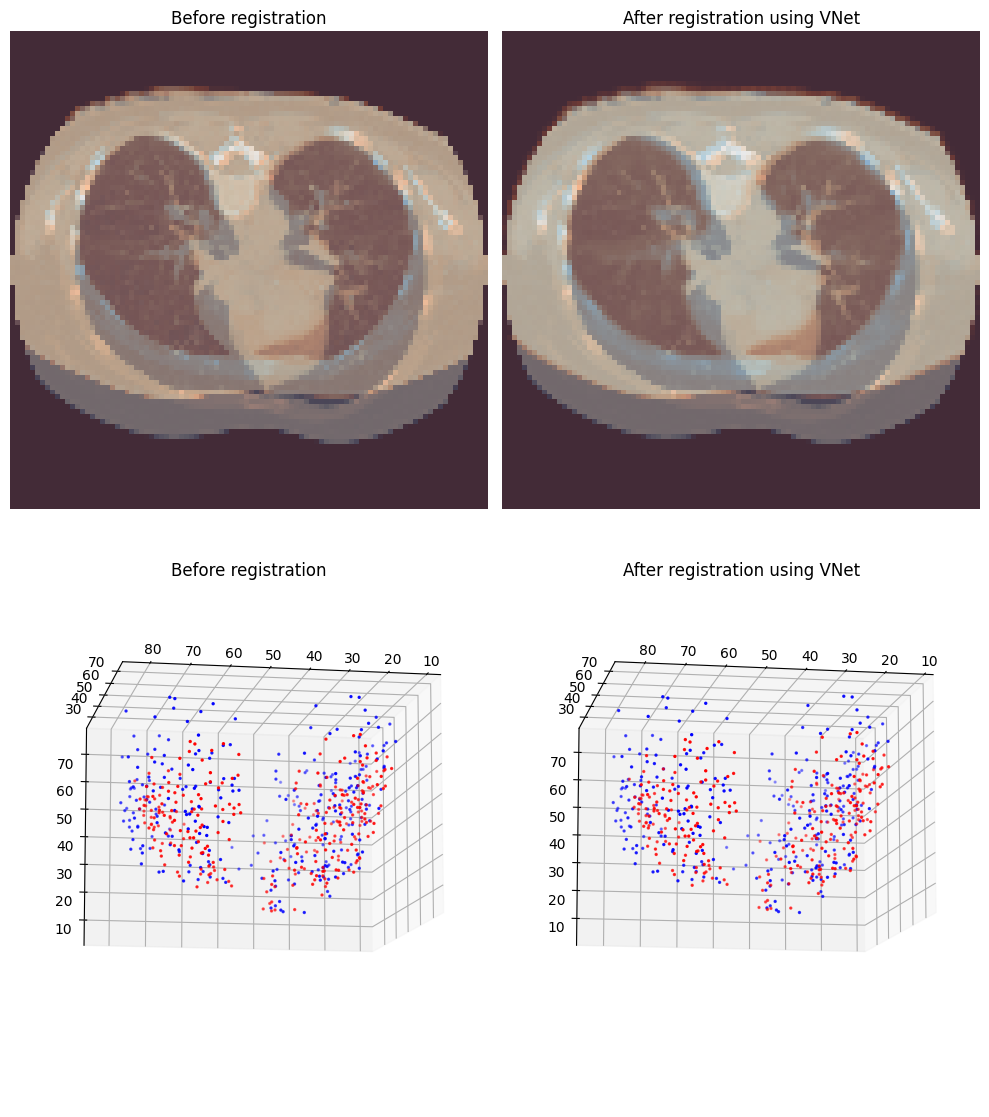

In [167]:
load_pretrained_model_weights = False
if load_pretrained_model_weights:
    dir_load = dir_save  # folder where network weights are stored
    # instantiate warp layer
    warp_layer = Warp()
    # instantiate model
    model = VNet(spatial_dims=3, in_channels=2, out_channels=3, act=('elu', {'inplace': True}), 
             dropout_prob=0.2, dropout_prob_down=0.5, dropout_prob_up=(0.5, 0.5), dropout_dim=3, bias=False)
    # load model weights
    filename_best_model = glob.glob(os.path.join(dir_load, "VNet_kpt_loss_best_tre*"))[0]
    model.load_state_dict(torch.load(filename_best_model))
    # to GPU
    model.to(device)

set_determinism(seed=1)
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)

# Forward pass
model.eval()
with torch.no_grad():
    ddf_image, ddf_keypoints, pred_image = forward(
            check_data["fixed_image"],
            check_data["moving_image"],
            check_data["fixed_landmarks"],
            model,
            warp_layer,
        )
        
        
def overlay_img(img1, img2, slice_idx, ax, title=None):
    ax.imshow(1 - img1[:, :, slice_idx], cmap="Blues", origin="lower")
    ax.imshow(1 - img2[:, :, slice_idx], cmap="Oranges", origin="lower", alpha=0.5)
    if title is not None:
        ax.set_title(title)  # Use set_title instead of title.set_text

# Image and label visualization
fixed_image = check_data["fixed_image"][0][0].permute(1, 0, 2)
moving_image = check_data["moving_image"][0][0].permute(1, 0, 2)
pred_image = pred_image[0][0].permute(1, 0, 2)

# Pointcloud visualization
fixed_keypoints = check_data["fixed_landmarks"][0]
moving_keypoints = check_data["moving_landmarks"][0]
moved_keypoints = fixed_keypoints + ddf_keypoints[0]

# Plot images and pointclouds
fig, axs = plt.subplots(2, 2, figsize=(10, 12)) 

# Image visualizations
slice_idx = int(target_res[0] * 95.0 / 224) 
overlay_img(fixed_image, moving_image, slice_idx, axs[0, 0], "Before registration")
overlay_img(fixed_image, pred_image, slice_idx, axs[0, 1], "After registration using VNet")

# Pointcloud visualizations
ax = fig.add_subplot(2, 2, 3, projection="3d")
ax.scatter(fixed_keypoints[:, 0], fixed_keypoints[:, 1], fixed_keypoints[:, 2], s=2.0, marker="o", color="blue")
ax.scatter(moving_keypoints[:, 0], moving_keypoints[:, 1], moving_keypoints[:, 2], s=2.0, marker="o", color="red")
ax.view_init(-10, 80)
ax.set_aspect("auto")
ax.set_title("Before registration")

ax = fig.add_subplot(2, 2, 4, projection="3d")
ax.scatter(moved_keypoints[:, 0], moved_keypoints[:, 1], moved_keypoints[:, 2], s=2.0, marker="o", color="blue")
ax.scatter(moving_keypoints[:, 0], moving_keypoints[:, 1], moving_keypoints[:, 2], s=2.0, marker="o", color="red")
ax.view_init(-10, 80)
ax.set_aspect("auto")
ax.set_title("After registration using VNet")

# Set axis off for image visualizations
for ax in axs[:, :].flat:
    ax.set_axis_off()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [165]:
# Compute predicted TRE for validation dataset
_, predicted_tre_val = compute_tre_for_dataset(model, val_loader, warp_layer, vx=vx)

# Display the results in a table
df_results_val = pd.DataFrame({
    #"Case": range(1, len(predicted_tre_val) + 1),
    "Case": 4,
    "VNet Predicted TRE (Validation)": predicted_tre_val,
})

# Compute predicted TRE for training dataset
_, predicted_tre_train = compute_tre_for_dataset(model, train_loader, warp_layer, vx=vx)

# Display the results in a table
df_results_train = pd.DataFrame({
    "Case": range(1, len(predicted_tre_train) + 1),
    "VNet Predicted TRE (Training)": predicted_tre_train
})

# Display the combined results
print(df_results_train)
print(df_results_val)

   Case VNet Predicted TRE (Training)
0     1            metatensor(3.3773)
1     2            metatensor(3.2669)
2     3            metatensor(4.0019)
   Case VNet Predicted TRE (Validation)
0     4              metatensor(4.1112)


Autoencoder

In [168]:
from monai.networks.nets import AutoEncoder

# Model
model = AutoEncoder(spatial_dims = 3, in_channels = 2, out_channels = 3,  channels=(2, 4, 8), strides=(2, 2, 2), 
                    kernel_size=3, up_kernel_size=3, num_res_units=0, inter_channels=None, 
                    inter_dilations=None, num_inter_units=2, act='PRELU', norm='INSTANCE', dropout=None, bias=True, padding=None)
warp_layer = Warp()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs)



In [169]:
# Tensorboard
if do_save:
    writer = SummaryWriter(log_dir=dir_save)

# Training loop
val_interval = 1
best_eval_tre = float("inf")
log_train_loss = []
log_train_tre = []
log_val_tre = []
log_val_loss = []

pth_best_tre, pth_latest = "", ""

for epoch in range(max_epochs):
    # ==============================================
    # Train
    # ==============================================
    t0_train = time.time()
    model.train()

    epoch_loss, n_steps, tre_before, tre_after = 0, 0, 0, 0
    for batch_data in train_loader:
        # Get data
        fixed_image = batch_data["fixed_image"]
        moving_image = batch_data["moving_image"]
        fixed_keypoints = batch_data["fixed_landmarks"]
        moving_keypoints = batch_data["moving_landmarks"]
        n_steps += 1
        # Forward pass and loss
        optimizer.zero_grad()
        ddf_image, ddf_keypoints, pred_image = forward(
            fixed_image, moving_image, fixed_keypoints, model, warp_layer
        )
        loss = loss_fun(
            fixed_image,
            pred_image,
            fixed_keypoints + ddf_keypoints,
            moving_keypoints,
            ddf_image,
            lam_t,
            lam_m,
            lam_r,
        )
        # Optimise
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # TRE before (voxel space)
        tre_before += tre(fixed_keypoints, moving_keypoints, vx = vx)
        tre_after += tre(fixed_keypoints + ddf_keypoints, moving_keypoints, vx = vx)

    # Scheduler step
    lr_scheduler.step()
    # Loss
    epoch_loss /= n_steps
    tre_before /= n_steps
    tre_after /= n_steps
    log_train_tre.append(tre_after.item())
    log_train_loss.append(epoch_loss)
    if do_save:
        writer.add_scalar("train_loss", epoch_loss, epoch)
    print(f"{epoch + 1} | loss={epoch_loss:.6f}")

    # Mean TRE
    tre_before /= n_steps
    tre_after /= n_steps
    print(
            f"{epoch + 1} | tre_before_train={tre_before:.3f}, tre_after_train={tre_after:.3f}, elapsed time: {time.time()-t0_train:.2f} sec."
    )

    # ==============================================
    # Eval
    # ==============================================
    if (epoch + 1) % val_interval == 0:
        t0_eval = time.time()
        model.eval()

        val_epoch_loss , n_steps, tre_before, tre_after = 0, 0, 0, 0
        with torch.no_grad():
            for batch_data in val_loader:
                # Get data
                fixed_image = batch_data["fixed_image"]
                moving_image = batch_data["moving_image"]
                fixed_keypoints = batch_data["fixed_landmarks"]
                moving_keypoints = batch_data["moving_landmarks"]
                n_steps += 1

                # Infer
                ddf_image, ddf_keypoints, pred_image = forward(
                    fixed_image, moving_image, fixed_keypoints, model, warp_layer
                )

                # Loss for validation
                val_loss = loss_fun(
                    fixed_image,
                    pred_image,
                    fixed_keypoints + ddf_keypoints,
                    moving_keypoints,
                    ddf_image,
                    lam_t,
                    lam_m,
                    lam_r,
                )
                val_epoch_loss += val_loss.item()

                # TRE

                tre_before += tre(fixed_keypoints , moving_keypoints, vx=vx)
                tre_after += tre(fixed_keypoints + ddf_keypoints, moving_keypoints, vx=vx)

        # Mean TRE
        tre_before /= n_steps
        tre_after /= n_steps
        val_epoch_loss /= n_steps
        log_val_loss.append(val_epoch_loss)
        log_val_tre.append(tre_after.item())
        if do_save:
            writer.add_scalar("val_tre", tre_after, epoch)
       

        print(
            f"{epoch + 1} | tre_before_val={tre_before:.3f}, tre_after_val={tre_after:.3f}, elapsed time: {time.time() - t0_train:.2f} sec."
            )


        if tre_after < best_eval_tre:
            best_eval_tre = tre_after
            if do_save:
                # Save best model based on TRE
                if pth_best_tre != "":
                    os.remove(os.path.join(dir_save, pth_best_tre))
                pth_best_tre = f"Autoencoder_kpt_loss_best_tre_{epoch + 1}_{best_eval_tre:.3f}.pth"
                torch.save(model.state_dict(), os.path.join(dir_save, pth_best_tre))
                print(f"{epoch + 1} | Saving best TRE model: {pth_best_tre}")

        if do_save:
            # Save latest model
            if pth_latest != "":
                os.remove(os.path.join(dir_save, pth_latest))
            pth_latest = "Autoencoder_kpt_loss_latest.pth"
            torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))


1 | loss=6.030278
1 | tre_before_train=6.413, tre_after_train=6.341, elapsed time: 0.95 sec.
1 | tre_before_val=30.364, tre_after_val=30.315, elapsed time: 1.22 sec.
1 | Saving best TRE model: Autoencoder_kpt_loss_best_tre_1_30.315.pth
2 | loss=6.100541
2 | tre_before_train=6.512, tre_after_train=6.459, elapsed time: 1.01 sec.
2 | tre_before_val=30.364, tre_after_val=30.313, elapsed time: 1.14 sec.
2 | Saving best TRE model: Autoencoder_kpt_loss_best_tre_2_30.313.pth
3 | loss=6.063825
3 | tre_before_train=6.479, tre_after_train=6.414, elapsed time: 0.96 sec.
3 | tre_before_val=30.364, tre_after_val=30.311, elapsed time: 1.09 sec.
3 | Saving best TRE model: Autoencoder_kpt_loss_best_tre_3_30.311.pth
4 | loss=6.063401
4 | tre_before_train=6.454, tre_after_train=6.393, elapsed time: 0.92 sec.
4 | tre_before_val=30.364, tre_after_val=30.310, elapsed time: 1.04 sec.
4 | Saving best TRE model: Autoencoder_kpt_loss_best_tre_4_30.310.pth
5 | loss=6.161222
5 | tre_before_train=6.589, tre_after_

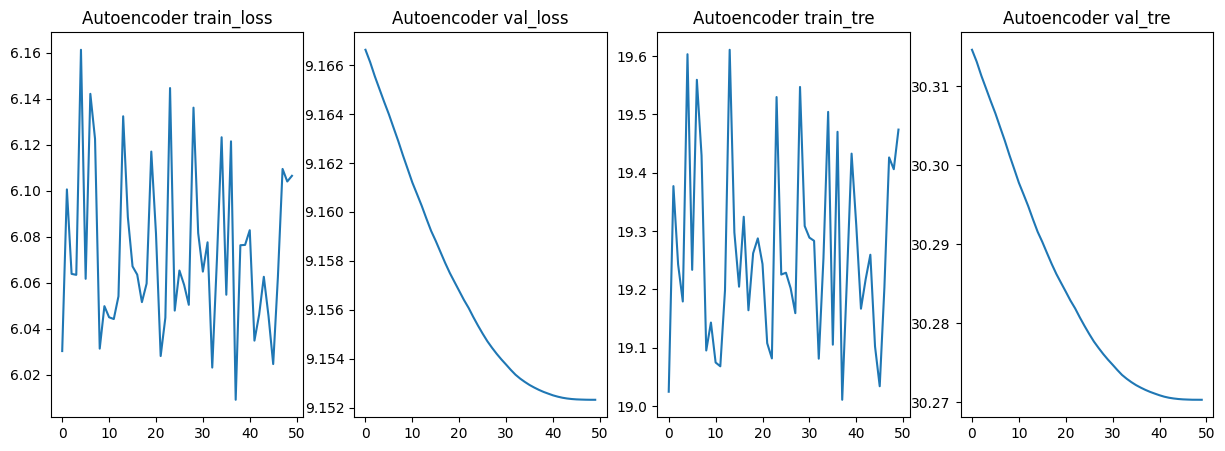

In [170]:
# log_val_tre = [x.item() for x in log_val_tre]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].plot(log_train_loss)
axs[0].title.set_text("Autoencoder train_loss")
axs[1].plot(log_val_loss)
axs[1].title.set_text("Autoencoder val_loss")
axs[2].plot(log_train_tre)
axs[2].title.set_text("Autoencoder train_tre")
axs[3].plot(log_val_tre)
axs[3].title.set_text("Autoencoder val_tre")
plt.show()

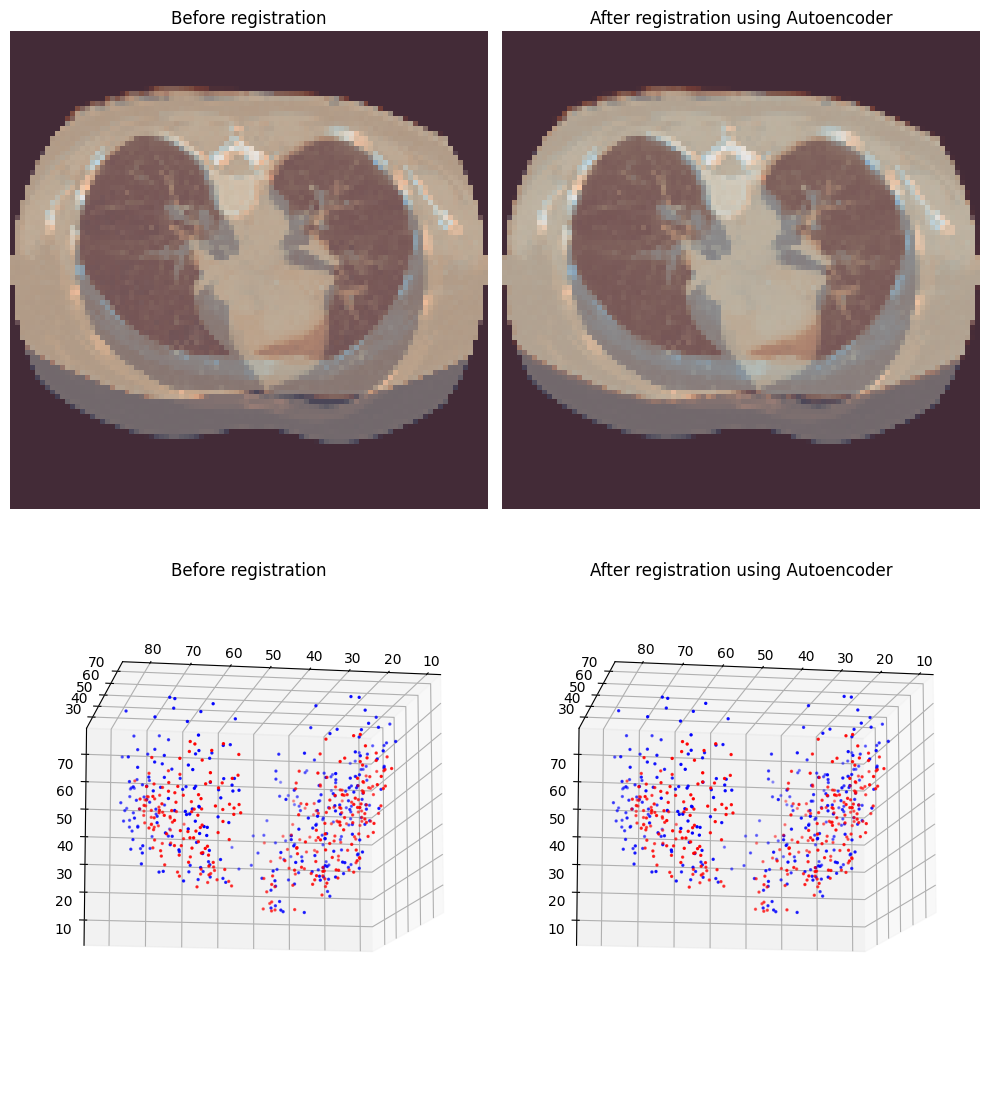

In [173]:
load_pretrained_model_weights = False
if load_pretrained_model_weights:
    dir_load = dir_save  # folder where network weights are stored
    # instantiate warp layer
    warp_layer = Warp()
    # instantiate model
    model = VNet(spatial_dims=3, in_channels=2, out_channels=3, act=('elu', {'inplace': True}), 
             dropout_prob=0.2, dropout_prob_down=0.5, dropout_prob_up=(0.5, 0.5), dropout_dim=3, bias=False)
    # load model weights
    filename_best_model = glob.glob(os.path.join(dir_load, "Autoencoder_kpt_loss_best_tre*"))[0]
    model.load_state_dict(torch.load(filename_best_model))
    # to GPU
    model.to(device)

set_determinism(seed=1)
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)

# Forward pass
model.eval()
with torch.no_grad():
    ddf_image, ddf_keypoints, pred_image = forward(
            check_data["fixed_image"],
            check_data["moving_image"],
            check_data["fixed_landmarks"],
            model,
            warp_layer,
        )
        
        
def overlay_img(img1, img2, slice_idx, ax, title=None):
    ax.imshow(1 - img1[:, :, slice_idx], cmap="Blues", origin="lower")
    ax.imshow(1 - img2[:, :, slice_idx], cmap="Oranges", origin="lower", alpha=0.5)
    if title is not None:
        ax.set_title(title)  # Use set_title instead of title.set_text

# Image and label visualization
fixed_image = check_data["fixed_image"][0][0].permute(1, 0, 2)
moving_image = check_data["moving_image"][0][0].permute(1, 0, 2)
pred_image = pred_image[0][0].permute(1, 0, 2)

# Pointcloud visualization
fixed_keypoints = check_data["fixed_landmarks"][0]
moving_keypoints = check_data["moving_landmarks"][0]
moved_keypoints = fixed_keypoints + ddf_keypoints[0]

# Plot images and pointclouds
fig, axs = plt.subplots(2, 2, figsize=(10, 12)) 

# Image visualizations
slice_idx = int(target_res[0] * 95.0 / 224) 
overlay_img(fixed_image, moving_image, slice_idx, axs[0, 0], "Before registration")
overlay_img(fixed_image, pred_image, slice_idx, axs[0, 1], "After registration using Autoencoder")

# Pointcloud visualizations
ax = fig.add_subplot(2, 2, 3, projection="3d")
ax.scatter(fixed_keypoints[:, 0], fixed_keypoints[:, 1], fixed_keypoints[:, 2], s=2.0, marker="o", color="blue")
ax.scatter(moving_keypoints[:, 0], moving_keypoints[:, 1], moving_keypoints[:, 2], s=2.0, marker="o", color="red")
ax.view_init(-10, 80)
ax.set_aspect("auto")
ax.set_title("Before registration")

ax = fig.add_subplot(2, 2, 4, projection="3d")
ax.scatter(moved_keypoints[:, 0], moved_keypoints[:, 1], moved_keypoints[:, 2], s=2.0, marker="o", color="blue")
ax.scatter(moving_keypoints[:, 0], moving_keypoints[:, 1], moving_keypoints[:, 2], s=2.0, marker="o", color="red")
ax.view_init(-10, 80)
ax.set_aspect("auto")
ax.set_title("After registration using Autoencoder")

# Set axis off for image visualizations
for ax in axs[:, :].flat:
    ax.set_axis_off()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [177]:
# Compute predicted TRE for validation dataset
_, predicted_tre_val = compute_tre_for_dataset(model, val_loader, warp_layer, vx=vx)

# Display the results in a table
df_results_val = pd.DataFrame({
    #"Case": range(1, len(predicted_tre_val) + 1),
    "Case": 4,
    "Autoencoder Predicted TRE (Validation)": predicted_tre_val,
})

# Compute predicted TRE for training dataset
_, predicted_tre_train = compute_tre_for_dataset(model, train_loader, warp_layer, vx=vx)

# Display the results in a table
df_results_train = pd.DataFrame({
    "Case": range(1, len(predicted_tre_train) + 1),
    "Autoencoder Predicted TRE (Training)": predicted_tre_train
})

# Display the combined results
print(df_results_train)
print(df_results_val)

   Case Autoencoder Predicted TRE (Training)
0     1                   metatensor(0.5788)
1     2                   metatensor(0.5662)
2     3                   metatensor(0.5765)
   Case Autoencoder Predicted TRE (Validation)
0     4                     metatensor(0.5530)


HighResNet

In [139]:
from monai.networks.nets import HighResNet

# Model
model = HighResNet(spatial_dims=3, in_channels=2, out_channels=3, norm_type=('batch', {'affine': True}), acti_type=('relu', {'inplace': True}), dropout_prob=0.0, bias=False, 
                   layer_params=({'kernel_size': 3, 'n_features': 16, 'name': 'conv_0'}, {'kernels': (3, 3), 'n_features': 16, 'name': 'res_1', 'repeat': 3}, {'kernels': (3, 3), 'n_features': 32, 'name': 'res_2', 'repeat': 3}, {'kernels': (3, 3), 'n_features': 64, 'name': 'res_3', 'repeat': 3}, {'kernel_size': 1, 'n_features': 80, 'name': 'conv_1'}, {'kernel_size': 1, 'name': 'conv_2'}), channel_matching= 'pad')
warp_layer = Warp()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs)



In [140]:
# Tensorboard
if do_save:
    writer = SummaryWriter(log_dir=dir_save)

# Training loop
val_interval = 1
best_eval_tre = float("inf")
log_train_loss = []
log_train_tre = []
log_val_tre = []
log_val_loss = []

pth_best_tre, pth_latest = "", ""

for epoch in range(max_epochs):
    # ==============================================
    # Train
    # ==============================================
    t0_train = time.time()
    model.train()

    epoch_loss, n_steps, tre_before, tre_after = 0, 0, 0, 0
    for batch_data in train_loader:
        # Get data
        fixed_image = batch_data["fixed_image"]
        moving_image = batch_data["moving_image"]
        fixed_keypoints = batch_data["fixed_landmarks"]
        moving_keypoints = batch_data["moving_landmarks"]
        n_steps += 1
        # Forward pass and loss
        optimizer.zero_grad()
        ddf_image, ddf_keypoints, pred_image = forward(
            fixed_image, moving_image, fixed_keypoints, model, warp_layer
        )
        loss = loss_fun(
            fixed_image,
            pred_image,
            fixed_keypoints + ddf_keypoints,
            moving_keypoints,
            ddf_image,
            lam_t,
            lam_m,
            lam_r,
        )
        # Optimise
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # TRE before (voxel space)
        tre_before += tre(fixed_keypoints, moving_keypoints, vx = vx)
        tre_after += tre(fixed_keypoints + ddf_keypoints, moving_keypoints, vx = vx)

    # Scheduler step
    lr_scheduler.step()
    # Loss
    epoch_loss /= n_steps
    tre_before /= n_steps
    tre_after /= n_steps
    log_train_tre.append(tre_after.item())
    log_train_loss.append(epoch_loss)
    if do_save:
        writer.add_scalar("train_loss", epoch_loss, epoch)
    print(f"{epoch + 1} | loss={epoch_loss:.6f}")

    # Mean TRE
    tre_before /= n_steps
    tre_after /= n_steps
    print(
            f"{epoch + 1} | tre_before_train={tre_before:.3f}, tre_after_train={tre_after:.3f}, elapsed time: {time.time()-t0_train:.2f} sec."
    )

    # ==============================================
    # Eval
    # ==============================================
    if (epoch + 1) % val_interval == 0:
        t0_eval = time.time()
        model.eval()

        val_epoch_loss , n_steps, tre_before, tre_after = 0, 0, 0, 0
        with torch.no_grad():
            for batch_data in val_loader:
                # Get data
                fixed_image = batch_data["fixed_image"]
                moving_image = batch_data["moving_image"]
                fixed_keypoints = batch_data["fixed_landmarks"]
                moving_keypoints = batch_data["moving_landmarks"]
                n_steps += 1

                # Infer
                ddf_image, ddf_keypoints, pred_image = forward(
                    fixed_image, moving_image, fixed_keypoints, model, warp_layer
                )

                # Loss for validation
                val_loss = loss_fun(
                    fixed_image,
                    pred_image,
                    fixed_keypoints + ddf_keypoints,
                    moving_keypoints,
                    ddf_image,
                    lam_t,
                    lam_m,
                    lam_r,
                )
                val_epoch_loss += val_loss.item()

                # TRE

                tre_before += tre(fixed_keypoints , moving_keypoints, vx=vx)
                tre_after += tre(fixed_keypoints + ddf_keypoints, moving_keypoints, vx=vx)

        # Mean TRE
        tre_before /= n_steps
        tre_after /= n_steps
        val_epoch_loss /= n_steps
        log_val_loss.append(val_epoch_loss)
        log_val_tre.append(tre_after.item())
        if do_save:
            writer.add_scalar("val_tre", tre_after, epoch)
       

        print(
            f"{epoch + 1} | tre_before_val={tre_before:.3f}, tre_after_val={tre_after:.3f}, elapsed time: {time.time() - t0_train:.2f} sec."
            )


        if tre_after < best_eval_tre:
            best_eval_tre = tre_after
            if do_save:
                # Save best model based on TRE
                if pth_best_tre != "":
                    os.remove(os.path.join(dir_save, pth_best_tre))
                pth_best_tre = f"HighResnet_kpt_loss_best_tre_{epoch + 1}_{best_eval_tre:.3f}.pth"
                torch.save(model.state_dict(), os.path.join(dir_save, pth_best_tre))
                print(f"{epoch + 1} | Saving best TRE model: {pth_best_tre}")

        if do_save:
            # Save latest model
            if pth_latest != "":
                os.remove(os.path.join(dir_save, pth_latest))
            pth_latest = "HighResnet_kpt_loss_latest.pth"
            torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))


1 | loss=5.748652
1 | tre_before_train=6.485, tre_after_train=6.151, elapsed time: 231.29 sec.
1 | tre_before_val=30.364, tre_after_val=30.403, elapsed time: 240.83 sec.
1 | Saving best TRE model: HighResnet_kpt_loss_best_tre_1_30.403.pth
2 | loss=5.010546
2 | tre_before_train=6.504, tre_after_train=5.405, elapsed time: 154.26 sec.
2 | tre_before_val=30.364, tre_after_val=30.448, elapsed time: 164.71 sec.
3 | loss=4.653946
3 | tre_before_train=6.448, tre_after_train=5.012, elapsed time: 160.83 sec.
3 | tre_before_val=30.364, tre_after_val=30.369, elapsed time: 171.12 sec.
3 | Saving best TRE model: HighResnet_kpt_loss_best_tre_3_30.369.pth
4 | loss=4.753556
4 | tre_before_train=6.508, tre_after_train=5.123, elapsed time: 174.83 sec.
4 | tre_before_val=30.364, tre_after_val=30.249, elapsed time: 184.86 sec.
4 | Saving best TRE model: HighResnet_kpt_loss_best_tre_4_30.249.pth
5 | loss=4.781235
5 | tre_before_train=6.501, tre_after_train=5.208, elapsed time: 167.01 sec.
5 | tre_before_val

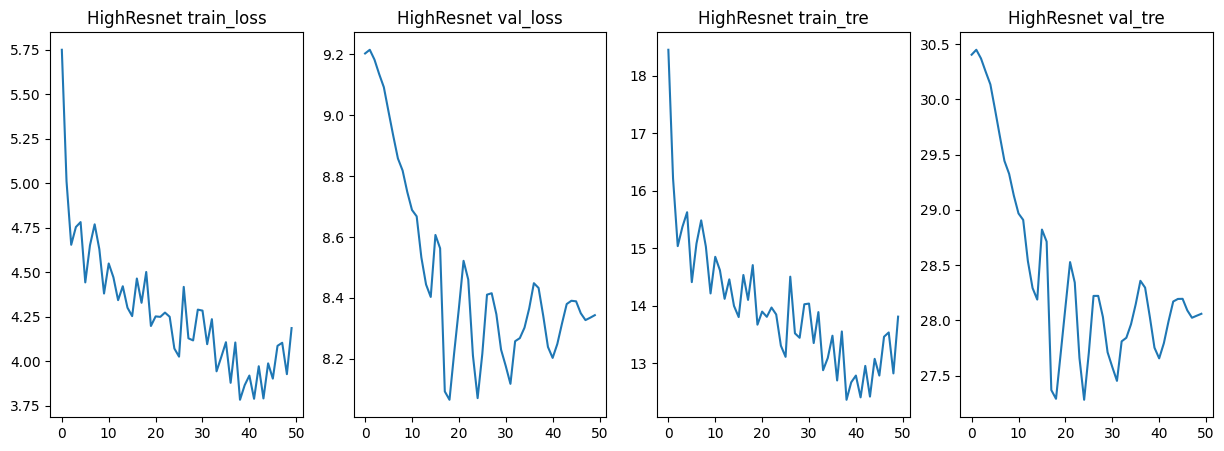

In [141]:
# log_val_tre = [x.item() for x in log_val_tre]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].plot(log_train_loss)
axs[0].title.set_text("HighResnet train_loss")
axs[1].plot(log_val_loss)
axs[1].title.set_text("HighResnet val_loss")
axs[2].plot(log_train_tre)
axs[2].title.set_text("HighResnet train_tre")
axs[3].plot(log_val_tre)
axs[3].title.set_text("HighResnet val_tre")
plt.show()

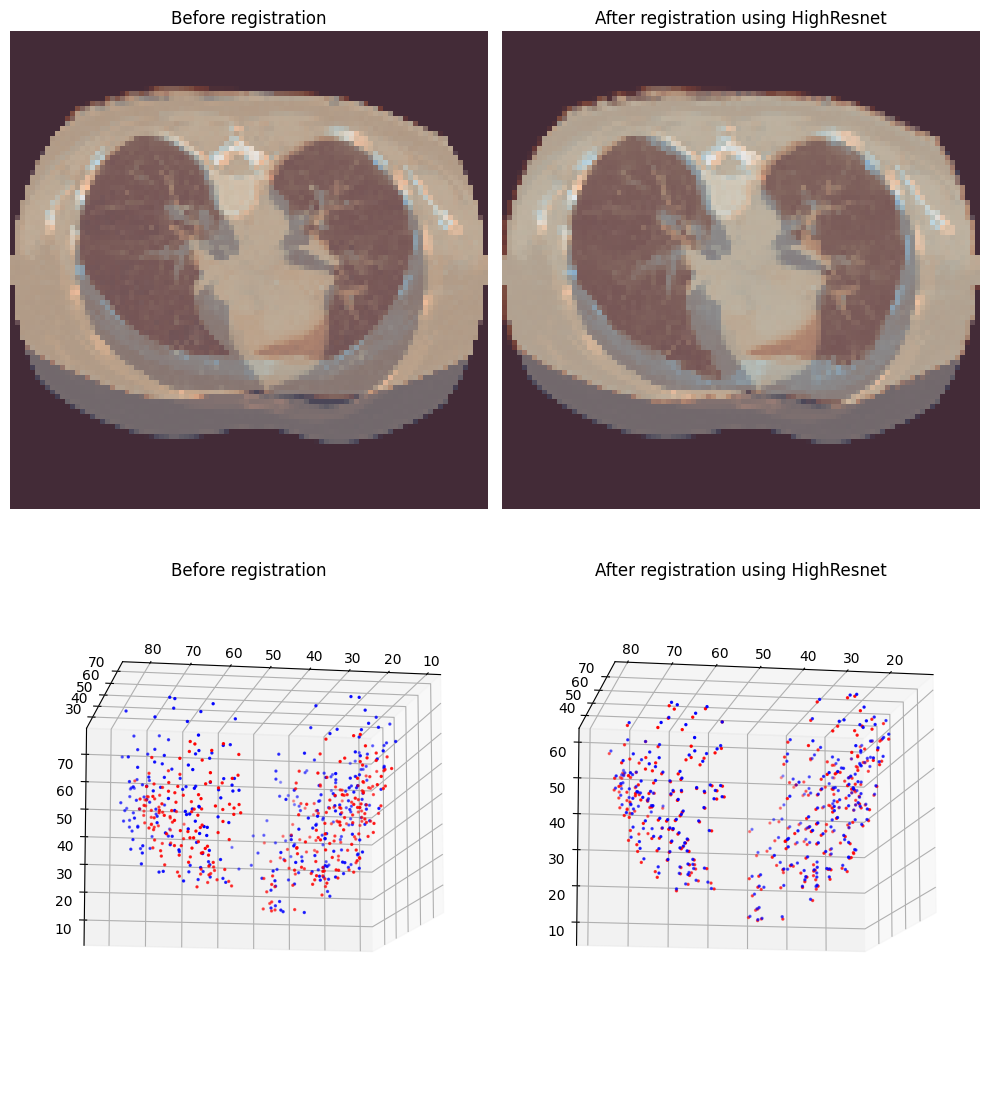

In [145]:
load_pretrained_model_weights = False
if load_pretrained_model_weights:
    dir_load = dir_save  # folder where network weights are stored
    # instantiate warp layer
    warp_layer = Warp()
    # instantiate model
    model = VNet(spatial_dims=3, in_channels=2, out_channels=3, act=('elu', {'inplace': True}), 
             dropout_prob=0.2, dropout_prob_down=0.5, dropout_prob_up=(0.5, 0.5), dropout_dim=3, bias=False)
    # load model weights
    filename_best_model = glob.glob(os.path.join(dir_load, "HighResnet_kpt_loss_best_tre*"))[0]
    model.load_state_dict(torch.load(filename_best_model))
    # to GPU
    model.to(device)

set_determinism(seed=1)
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)

# Forward pass
model.eval()
with torch.no_grad():
    ddf_image, ddf_keypoints, pred_image = forward(
            check_data["fixed_image"],
            check_data["moving_image"],
            check_data["fixed_landmarks"],
            model,
            warp_layer,
        )
        
        
def overlay_img(img1, img2, slice_idx, ax, title=None):
    ax.imshow(1 - img1[:, :, slice_idx], cmap="Blues", origin="lower")
    ax.imshow(1 - img2[:, :, slice_idx], cmap="Oranges", origin="lower", alpha=0.5)
    if title is not None:
        ax.set_title(title)  # Use set_title instead of title.set_text

# Image and label visualization
fixed_image = check_data["fixed_image"][0][0].permute(1, 0, 2)
moving_image = check_data["moving_image"][0][0].permute(1, 0, 2)
pred_image = pred_image[0][0].permute(1, 0, 2)

# Pointcloud visualization
fixed_keypoints = check_data["fixed_landmarks"][0]
moving_keypoints = check_data["moving_landmarks"][0]
moved_keypoints = fixed_keypoints + ddf_keypoints[0]

# Plot images and pointclouds
fig, axs = plt.subplots(2, 2, figsize=(10, 12)) 

# Image visualizations
slice_idx = int(target_res[0] * 95.0 / 224) 
overlay_img(fixed_image, moving_image, slice_idx, axs[0, 0], "Before registration")
overlay_img(fixed_image, pred_image, slice_idx, axs[0, 1], "After registration using HighResnet")

# Pointcloud visualizations
ax = fig.add_subplot(2, 2, 3, projection="3d")
ax.scatter(fixed_keypoints[:, 0], fixed_keypoints[:, 1], fixed_keypoints[:, 2], s=2.0, marker="o", color="blue")
ax.scatter(moving_keypoints[:, 0], moving_keypoints[:, 1], moving_keypoints[:, 2], s=2.0, marker="o", color="red")
ax.view_init(-10, 80)
ax.set_aspect("auto")
ax.set_title("Before registration")

ax = fig.add_subplot(2, 2, 4, projection="3d")
ax.scatter(moved_keypoints[:, 0], moved_keypoints[:, 1], moved_keypoints[:, 2], s=2.0, marker="o", color="blue")
ax.scatter(moving_keypoints[:, 0], moving_keypoints[:, 1], moving_keypoints[:, 2], s=2.0, marker="o", color="red")
ax.view_init(-10, 80)
ax.set_aspect("auto")
ax.set_title("After registration using HighResnet")

# Set axis off for image visualizations
for ax in axs[:, :].flat:
    ax.set_axis_off()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [159]:
# Compute predicted TRE for validation dataset
_, predicted_tre_val = compute_tre_for_dataset(model, val_loader, warp_layer, vx=vx)

# Display the results in a table
df_results_val = pd.DataFrame({
    #"Case": range(1, len(predicted_tre_val) + 1),
    "Case": 4,
    "HighResnet Predicted TRE (Val)": predicted_tre_val,
})

# Compute predicted TRE for training dataset
_, predicted_tre_train = compute_tre_for_dataset(model, train_loader, warp_layer, vx=vx)

# Display the results in a table
df_results_train = pd.DataFrame({
    "Case": range(1, len(predicted_tre_train) + 1),
    "HighResnet Predicted TRE (Train)": predicted_tre_train
})

# Display the combined results
print(df_results_train)
print(df_results_val)

   Case HighResnet Predicted TRE (Train)
0     1               metatensor(8.2021)
1     2              metatensor(11.3182)
2     3               metatensor(3.9731)
   Case HighResnet Predicted TRE (Val)
0     4             metatensor(6.1212)
